In [2]:
%matplotlib inline
import keras
import numpy as np
from matplotlib import pyplot as plt

RANDOM_SEED = 0xdeadbeef

# L11 Convolutional Neural Networks

# Task 1 (5 Points)

In this task you will build a Convolutional Neural Network (CNN) and apply it to the CIFAR10 dataset. CIFAR10 is an image classification dataset. The task is to classify 32x32 pixel images into one of 10 classes:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

In [3]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# convert image data from uint8 (0 - 255) to float32 [0., 1.]
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

class_names = [
  'airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck',
]


print("number of train samples: ", x_train.shape[0])
print("number of test samples: ", x_test.shape[0])
print("shape of a sample: ", x_train.shape[1:])

number of train samples:  50000
number of test samples:  10000
shape of a sample:  (32, 32, 3)


Let's visualize some of the sample images:

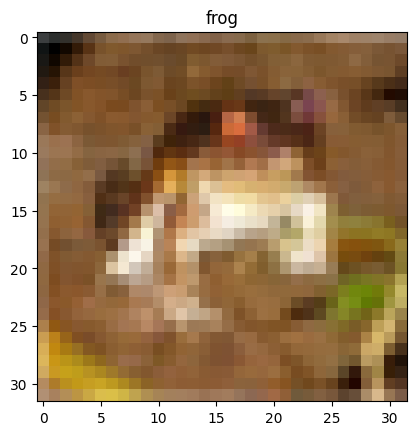

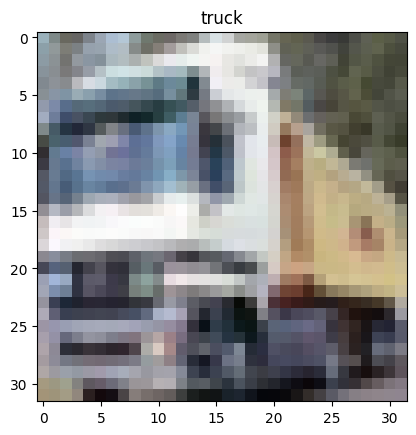

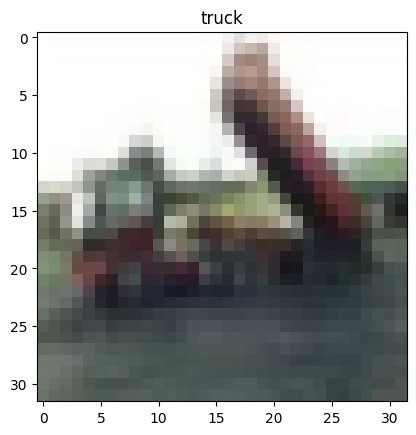

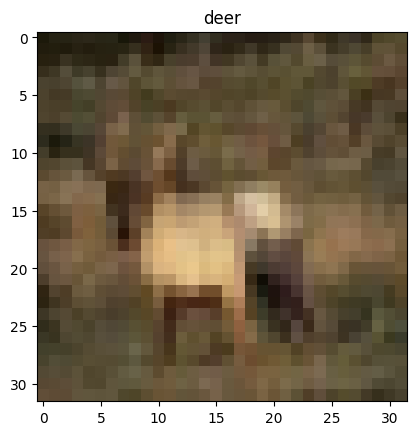

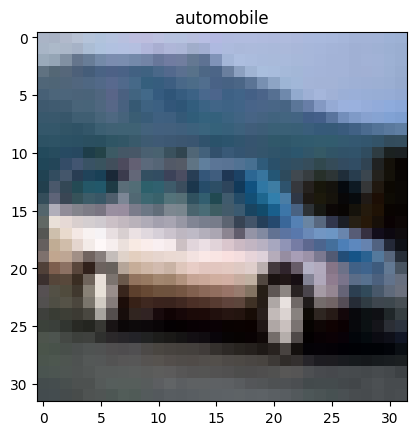

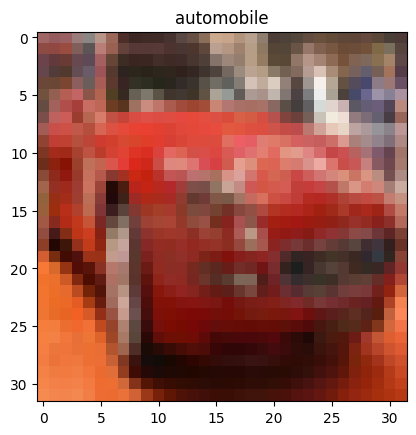

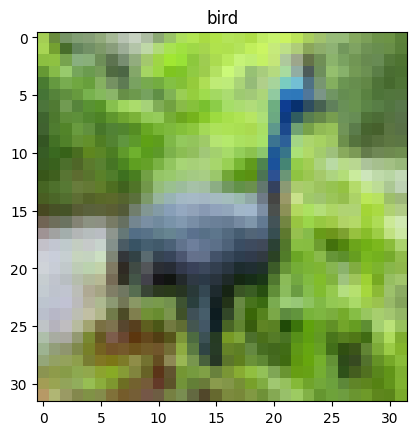

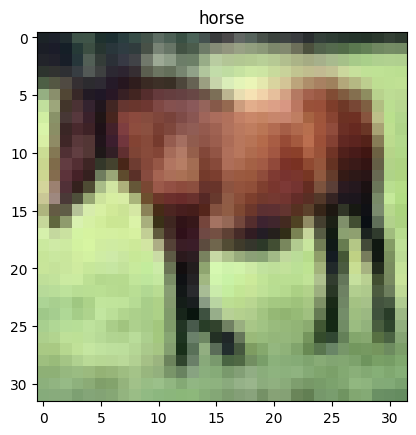

In [4]:
for i in range(8):
  plt.imshow(x_train[i, :, :, :])
  plt.title(class_names[y_train[i, 0]])
  plt.show()

# Convolutions

The main building block of a CNN is the **convolution** layer. Convolutions are a technique borrowed from digital signal processing.

The animation below shows the main idea how a convolution layer works in 2D. The bottom 7x7 array corresponds to the input image. The 3x3 darker patch moving over the input corresponds to the **filter**. The green array on top is the output (with the darker spot indicating which output element is computed currently).

The *filter* here is a 3x3 array of learnable parameters. To compute an output element, we multiply the filter and the current image patch elementwise and then sum over all 9 values.

<img src="https://upload.wikimedia.org/wikipedia/commons/8/85/Convolution_arithmetic_-_Full_padding_no_strides_transposed.gif"/>

<a href="https://commons.wikimedia.org/wiki/File:Convolution_arithmetic_-_Full_padding_no_strides_transposed.gif">Vincent Dumoulin, Francesco Visin</a>, <a href="http://opensource.org/licenses/mit-license.php">MIT</a>, via Wikimedia Commons

### Example convolution by hand

Below you see an example of a 3x3 convolution over a 5x5 image. On the left, in blue, you see the input array. In a darker shade you see the filter overlaid for computing the current output.

On the right, in green, you see the computed output array, with the current output in a darker shade.

Compute the value for the output marked "?".

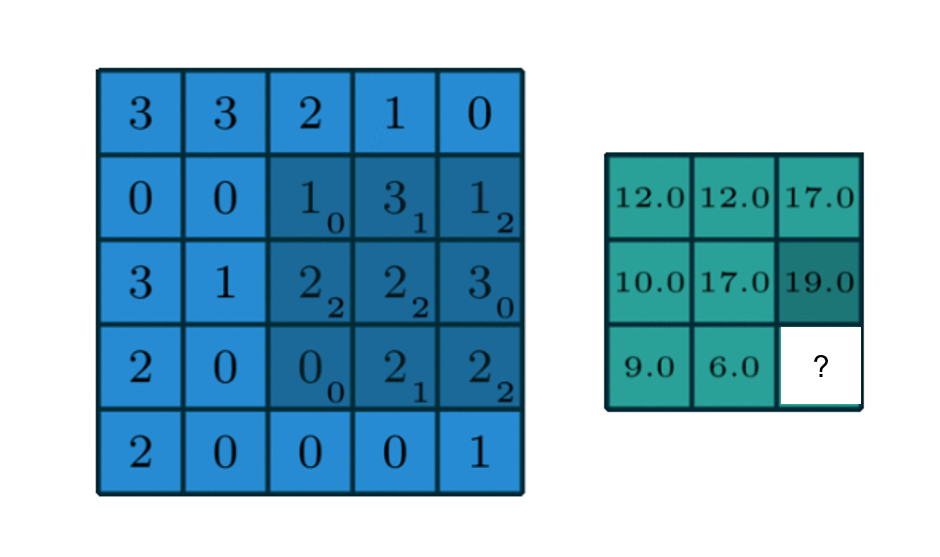

### Task 1a. (1 Point) Compute the last convolution output (marked "?")

## 📢 **HAND-IN** 📢: report in **Moodle** whether you solved this task


### Convolutions in Keras

In our examples so far, the arrays were all true 2D arrays. Images on the other hand are represented as multi-dimensional arrays. They have width, height, and a number of color channels (typically 3, e.g. red, green, and blue). This is reflected in the CIFAR10 data: the samples have shape (32, 32, 3). The "3" represent the 3 color channels.

When we apply a 2D convolution to image data, we slide the filter over the width and height dimensions and apply it to all channels at the same time.

In keras, this kind of convolution is implemented using the `Conv2D` layer.
Its main parameters are `kernel_size=(width, height)`, which specifies the size of the filter. In this lab, we will generally use 3x3 filters. The `filters` argument specifies how many filters we want to apply at the same time (basically, Conv2D applies multiple filters in parallel). This argument also determines the number of output dimensions. Finally, we can specify the desired activation function using the `activation` parameter.

An input to Conv2D is 4-dimensional of the shape `(batch_size, input_width, input_height, input_channels)` and has output shape `(batch_size, output_width, output_height, number_of_filters)`. The `output_width` and `output_height` are determined by `kernel_size` and `number_of_filters` is exactly the `filters` argument.

The main point of this is that the output of a `Conv2D` operation is compatible to be the input of another `Conv2D` operation, meaning we can apply multiple of them in sequence (similar do `Dense` layers for flat vector inputs).

In [5]:
from keras.layers import Conv2D

conv = Conv2D(filters=10, kernel_size=(3, 3), activation="sigmoid")

example_input = x_train[:1, :, :, :]
print("input shape: ", example_input.shape)

out = conv(example_input)

print("output shape: ", out.shape)

input shape:  (1, 32, 32, 3)
output shape:  (1, 30, 30, 10)


# Pooling

An another common component of CNNs are pooling layers. They are used to reduce the size of an input by subsampling.

For images we usually apply 2D max pooling. Meaning we subsample by only keeping the maximum of a certain patch.

In the next cell you see a figure showing 2x2 max pooling.

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a6/Max-pool_2x2.png"/>

<a href="https://commons.wikimedia.org/wiki/File:Max-pool_2x2.png">Zvignes</a>, <a href="https://creativecommons.org/licenses/by-sa/4.0">CC BY-SA 4.0</a>, via Wikimedia Commons

### Max Pooling in Keras

In keras this is implemented using a `MaxPooling2D` layer. Its main argument is
`pool_size=(widht, height)`. Where `width` and `height` are integers specifying how wide an high the pool should be. We will use 2x2 pools in this lab.

In [6]:
from keras.layers import MaxPooling2D

pool = MaxPooling2D(pool_size=(2, 2))

example_input = x_train[:1, :, :, :]
print("input shape: ", example_input.shape)

out = pool(example_input)

print("output shape: ", out.shape)

input shape:  (1, 32, 32, 3)
output shape:  (1, 16, 16, 3)


# A CNN for CIFAR10

You should now be able to implement a simple CNN for the CIFAR10 data.

In [7]:
# here we import everything you need to build the CNN
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten

To get you started we define the following CNN:
* an `Input` layer, specifying the correct `shape` of the input images
* a `Conv2D` layer with 32 3x3 filters and *relu* activation
* a 2x2 `MaxPooling2D` layer
* a `Flatten` layer to reshape the data into flat vectors
* a `Dense` layer with 10 units and *softmax* activation


In [8]:
model = Sequential()
model.add(Input(shape=(32, 32, 3)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 10)                72010     
                                                                 
Total params: 72,906
Trainable params: 72,906
Non-trainable params: 0
_________________________________________________________________


In the next cell, we train the CNN for 30 epochs.

In [9]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(
  x_train,
  y_train,
  epochs=30,
  batch_size=32,
  validation_split=.1,
)

Epoch 1/30
1407/1407 [==============================] - 25s 16ms/step - loss: 1.4992 - accuracy: 0.4754 - val_loss: 1.2828 - val_accuracy: 0.5618
Epoch 2/30
1407/1407 [==============================] - 26s 18ms/step - loss: 1.2258 - accuracy: 0.5744 - val_loss: 1.1986 - val_accuracy: 0.5822
Epoch 3/30
1407/1407 [==============================] - 29s 20ms/step - loss: 1.1292 - accuracy: 0.6102 - val_loss: 1.1333 - val_accuracy: 0.6178
Epoch 4/30
1405/1407 [============================>.] - ETA: 0s - loss: 1.0698 - accuracy: 0.6320

Below we plot the learning curve of the network:

In [ ]:
def plot_learning_curves(history):
  n = len(history.history['loss'])
  plt.plot(np.arange(1, n+1), history.history['loss'], label="training loss")
  plt.plot(np.arange(1, n+1), history.history['val_loss'], label="validation loss")
  plt.legend()
  plt.xticks(np.arange(1, n+1, 2))

In [ ]:
plot_learning_curves(history)

Finally, we evaluate the CNN on the test set using `classification_report` from `sklearn`. Which classes did it learn well? Which classes did it learn less well?

In [ ]:
from sklearn.metrics import classification_report

predicted_class_probabilities = model.predict(x_test)
predicted_labels = np.argmax(predicted_class_probabilities, axis=1)

print(classification_report(y_true=y_test, y_pred=predicted_labels, target_names=class_names))

### Task 1b. Modify the CNN (4 Points)

Your task is to extend this architecture: Add additional `Conv2D`, `MaxPooling2D`, and `Dense` layers. The goal is to improve the accuracy of the model. A good model can achieve > 68\% accuracy.

If you think it is appropriate you can also change the training procedure, for example by changing the number of epochs.

## 📢 **HAND-IN** 📢: report in **Moodle** whether you solved this task
